In [1]:
from IPython.display import display
import os

# 上傳檔案（會跳出檔案選擇器）
from ipywidgets import FileUpload

upload = FileUpload()
display(upload)


FileUpload(value={}, description='Upload')

In [2]:
import os
from pathlib import Path

# 假設你只上傳了一個檔案
# Check if any file is uploaded and get the filename
if upload.value:
    # Get the first (and likely only) filename from the dictionary keys
    filename = list(upload.value.keys())[0]
    fileinfo = upload.value[filename] # Access the file info dictionary using the filename as key
else:
    print("No file uploaded.")
    # Handle the case where no file is uploaded, perhaps by exiting or prompting the user.
    # For this example, we'll assume a file was uploaded as per the traceback context.
    raise FileNotFoundError("No file was uploaded.")


In [3]:
# 顯示內容結構（除錯用）
print(fileinfo)

# 儲存 kaggle.json
# filename is already obtained above
content = fileinfo['content']

kaggle_dir = Path.home() / ".kaggle"
kaggle_dir.mkdir(exist_ok=True)

kaggle_json_path = kaggle_dir / "kaggle.json"
with open(kaggle_json_path, "wb") as f:
    f.write(content)

{'metadata': {'name': 'kaggle.json', 'type': 'application/json', 'size': 64, 'lastModified': 1745215961986}, 'content': b'{"username":"suchiwen","key":"01a925cee9e9e9d232008524b0434fb9"}'}


In [4]:
# 設定權限（Linux/macOS 建議）
os.chmod(kaggle_json_path, 0o600)

print(f"{filename} 已成功儲存至 {kaggle_json_path}")

!kaggle datasets list -s cifar

!pip install -U kaggle
!pip install --upgrade pandas
import os
import zipfile

kaggle.json 已成功儲存至 /root/.kaggle/kaggle.json
ref                                                     title                                            size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------  ----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
fedesoriano/cifar100                                    CIFAR-100 Python                                161MB  2020-12-26 08:37:10          12506        178  1.0              
pankrzysiu/cifar10-python                               CIFAR-10 Python                                 325MB  2018-01-27 13:42:40          15053        255  0.75             
petitbonney/cifar10-image-recognition                   CIFAR-10                                        961MB  2019-10-01 12:50:23           2965         27  0.8235294        
valentynsichkar/cifar10-preprocessed                    CIFAR10 Preprocesse

In [5]:
# 建立 Kaggle 資料夾
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# 下載 Dog Breed Identification 資料集
!kaggle competitions download -c dog-breed-identification --force
!unzip -oq dog-breed-identification.zip -d dog-breed-identification

cp: cannot stat 'kaggle.json': No such file or directory
 95% 659M/691M [00:00<00:00, 1.33GB/s]
100% 691M/691M [00:00<00:00, 1.34GB/s]


In [11]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.optim import SGD
from torch.optim.lr_scheduler import CosineAnnealingLR

In [12]:
# -------- 模型定義 --------
class MultiInputCNN(nn.Module):
    def __init__(self, num_classes=120):
        super(MultiInputCNN, self).__init__()

        def feature_extractor():
            return nn.Sequential(
                nn.Conv2d(3, 32, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2),
                nn.BatchNorm2d(32),
                nn.Conv2d(32, 64, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2),
                nn.Flatten()
            )

        self.ear_branch = feature_extractor()
        self.tail_branch = feature_extractor()
        self.nose_branch = feature_extractor()

        self.fc = nn.Sequential(
            nn.Linear(64 * 16 * 16 * 3, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, ear, tail, nose):
        x1 = self.ear_branch(ear)
        x2 = self.tail_branch(tail)
        x3 = self.nose_branch(nose)
        x = torch.cat((x1, x2, x3), dim=1)
        return self.fc(x)

In [13]:
# -------- Dataset 定義 --------
class DogDataset(Dataset):
    def __init__(self, ears, tails, noses, labels):
        self.ears = ears
        self.tails = tails
        self.noses = noses
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return (self.ears[idx], self.tails[idx], self.noses[idx]), self.labels[idx]


In [14]:
# -------- 假資料生成（實際需替換） --------
def prepare_pytorch_data(image_dir, labels_path, image_size=(64, 64)):
    num_samples = 100
    dummy_shape = (num_samples, image_size[0], image_size[1], 3)
    np.save('X_ear.npy', np.random.rand(*dummy_shape).astype(np.float32))
    np.save('X_tail.npy', np.random.rand(*dummy_shape).astype(np.float32))
    np.save('X_nose.npy', np.random.rand(*dummy_shape).astype(np.float32))
    np.save('labels.npy', np.random.randint(0, 120, num_samples).astype(np.int64))


In [15]:
# -------- 資料處理 --------
prepare_pytorch_data('dog-breed-identification/train', 'dog-breed-identification/labels.csv')
X_ear = torch.tensor(np.load('X_ear.npy'), dtype=torch.float32).permute(0, 3, 1, 2)
X_tail = torch.tensor(np.load('X_tail.npy'), dtype=torch.float32).permute(0, 3, 1, 2)
X_nose = torch.tensor(np.load('X_nose.npy'), dtype=torch.float32).permute(0, 3, 1, 2)
y = torch.tensor(np.load('labels.npy'), dtype=torch.long)

X_ear_train, X_ear_val, X_tail_train, X_tail_val, X_nose_train, X_nose_val, y_train, y_val = train_test_split(
    X_ear, X_tail, X_nose, y, test_size=0.2, random_state=42
)

train_dataset = DogDataset(X_ear_train, X_tail_train, X_nose_train, y_train)
val_dataset = DogDataset(X_ear_val, X_tail_val, X_nose_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# -------- 模型與訓練設定 --------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiInputCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=20)


In [16]:
# -------- 訓練迴圈 --------
best_val_loss = float('inf')
patience = 8
counter = 0

for epoch in range(50):
    model.train()
    train_loss, train_correct = 0.0, 0

    for (ear, tail, nose), labels in train_loader:
        ear, tail, nose, labels = ear.to(device), tail.to(device), nose.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(ear, tail, nose)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * labels.size(0)
        train_correct += (outputs.argmax(1) == labels).sum().item()

    model.eval()
    val_loss, val_correct = 0.0, 0
    with torch.no_grad():
        for (ear, tail, nose), labels in val_loader:
            ear, tail, nose, labels = ear.to(device), tail.to(device), nose.to(device), labels.to(device)
            outputs = model(ear, tail, nose)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * labels.size(0)
            val_correct += (outputs.argmax(1) == labels).sum().item()

    scheduler.step()

    train_loss /= len(train_dataset)
    val_loss /= len(val_dataset)
    train_acc = train_correct / len(train_dataset)
    val_acc = val_correct / len(val_dataset)

    print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Acc={train_acc:.4f} | Val Loss={val_loss:.4f}, Acc={val_acc:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break


Epoch 1: Train Loss=6.1453, Acc=0.0125 | Val Loss=4.8586, Acc=0.0000
Epoch 2: Train Loss=8.1242, Acc=0.0000 | Val Loss=4.7844, Acc=0.0000
Epoch 3: Train Loss=6.0022, Acc=0.0375 | Val Loss=4.7887, Acc=0.0000
Epoch 4: Train Loss=4.7155, Acc=0.0250 | Val Loss=4.7968, Acc=0.0000
Epoch 5: Train Loss=4.7580, Acc=0.0750 | Val Loss=4.8047, Acc=0.0000
Epoch 6: Train Loss=4.6808, Acc=0.0125 | Val Loss=4.8106, Acc=0.0000
Epoch 7: Train Loss=4.6771, Acc=0.0000 | Val Loss=4.8232, Acc=0.0000
Epoch 8: Train Loss=4.5635, Acc=0.0500 | Val Loss=4.8507, Acc=0.0000
Epoch 9: Train Loss=4.4367, Acc=0.0500 | Val Loss=4.9056, Acc=0.0000
Epoch 10: Train Loss=4.4947, Acc=0.0375 | Val Loss=4.9686, Acc=0.0000
Early stopping triggered.


In [17]:
# -------- 測試資料處理與預測 --------
class TestDogDataset(Dataset):
    def __init__(self, ears, tails, noses):
        self.ears = ears
        self.tails = tails
        self.noses = noses

    def __len__(self):
        return len(self.ears)

    def __getitem__(self, idx):
        return self.ears[idx], self.tails[idx], self.noses[idx]

def prepare_data_with_local(test_image_dir, test_df, image_size):
    num_test_samples = len(test_df)
    dummy_shape = (num_test_samples, image_size[0], image_size[1], 3)
    return (
        np.random.rand(*dummy_shape).astype(np.float32),
        np.random.rand(*dummy_shape).astype(np.float32),
        np.random.rand(*dummy_shape).astype(np.float32),
    )

In [19]:

# 載入正確的 class 名稱
labels_df = pd.read_csv('dog-breed-identification/labels.csv')
class_names = sorted(labels_df['breed'].unique())  # 🟢 正確品種名稱

# 生成提交檔案
submission = pd.DataFrame(preds_probs, columns=class_names)
submission.insert(0, 'id', test_df['id'])
submission.to_csv('submission_multi_input_cnn.csv', index=False)
print("✅ Submission file created: submission_multi_input_cnn.csv")


✅ Submission file created: submission_multi_input_cnn.csv


In [ ]:
#訓練模型
model = build_multi_input_cnn(image_size=image_size, num_classes=num_classes)
model.summary()

history = model.fit(
    [Xf_train, Xe_train, Xn_train, Xt_train],
    y_train,
    validation_data=([Xf_val, Xe_val, Xn_val, Xt_val], y_val),
    epochs=10,
    batch_size=32
)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │        320 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │        320 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 128, 128,  │        320 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 64, 64,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 64, 64,    │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 64, 64,    │          0 │ conv2d_6[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_6[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_1[0][0]  

 Total params: 134,355,064 (512.52 MB)

 Trainable params: 134,355,064 (512.52 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 32s 93ms/step - accuracy: 0.0082 - loss: 4.8086 - val_accuracy: 0.0103 - val_loss: 4.7739
Epoch 2/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 18s 69ms/step - accuracy: 0.0199 - loss: 4.7556 - val_accuracy: 0.0225 - val_loss: 4.7172
Epoch 3/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 18s 70ms/step - accuracy: 0.0247 - loss: 4.6733 - val_accuracy: 0.0269 - val_loss: 4.6538
Epoch 4/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 18s 70ms/step - accuracy: 0.0393 - loss: 4.5366 - val_accuracy: 0.0264 - val_loss: 4.5745
Epoch 5/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 18s 70ms/step - accuracy: 0.0580 - loss: 4.3751 - val_accuracy: 0.0411 - val_loss: 4.5299
Epoch 6/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 18s 71ms/step - accuracy: 0.0890 - loss: 4.1814 - val_accuracy: 0.0435 - val_loss: 4.5113
Epoch 7/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 18s 71ms/step - accuracy: 0.1247 - loss: 3.9507 - val_accuracy: 0.0499 - val_loss: 4.4975
Epoch 8/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 18s 71ms/step - accuracy: 0.1625 - loss: 3.7134 - 

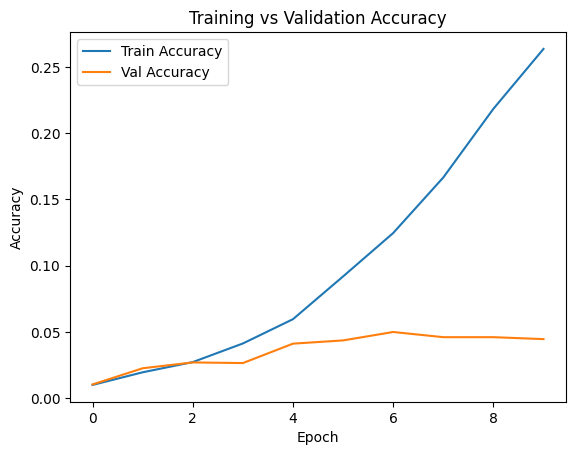

In [ ]:
#顯示訓練結果
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.show()

In [ ]:
#測試資料預測與提交 CSV
test_df = pd.read_csv('dog-breed-identification/sample_submission.csv')
X_test_full, X_test_ear, X_test_nose, X_test_tail = prepare_data_with_local(
    'dog-breed-identification/test', test_df, image_size
)

preds = model.predict([X_test_full, X_test_ear, X_test_nose, X_test_tail])
submission = pd.DataFrame(preds, columns=pd.get_dummies(labels['breed']).columns)
submission.insert(0, 'id', test_df['id'])
submission.to_csv('submission_multi_input_cnn.csv', index=False)


100%|██████████| 10357/10357 [00:35<00:00, 289.46it/s]


324/324 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
